In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from math import pi, log
import pandas as pd

# test version of residue/atoms NbIT mode. Default was 'residues'

In [1]:
mode = 'residues'    #atoms/residues

In [2]:
def entropy(i):
    j = np.where(np.in1d(atoms_ref.ids.tolist(), i)==True)[0].tolist()
    if len(j)>1:
        H = 0.5*len(j)*(1+log(2*pi))+0.5*np.linalg.slogdet(np.take(np.take(COV, j, axis = 0), j, axis = -1))[1]
        return H
    elif len(j)==1:
        H = 0.5*len(j)*(1+log(2*pi))+0.5*log(np.take(np.take(COV, j, axis = -1), j, axis = 0))
        return H
    else:
        return print('Wrong index format or no elements in the list were found')

def inf(i, j):
    if len(i)>=1 and len(j)>=1:
        Hi = entropy(i)
        Hj = entropy(j)
        Hij = entropy(np.unique(np.hstack((i, j))))
        return abs(Hi + Hj - Hij)
    else:
        print('Wrong index format or no elements in the list were found')

def mutual(COM):
    
    length = len(COM)
    mutual_out = np.empty((length, length))
    for i in range(length):
        for j in range(length):
            if i==j:
                mutual_out[i, j] = entropy(COM[i].ids.tolist())
            elif i< j:
                s1 = np.setdiff1d(COM[i].ids.tolist(), COM[j].ids.tolist(), assume_unique=True)                
                s2 = np.setdiff1d(COM[j].ids.tolist(), COM[i].ids.tolist(), assume_unique=True)                
                mutual_out[i, j] = inf(s1, s2)
            else:
                mutual_out[i, j] = 'NaN'
    return mutual_out


def correlation(i, ii):
    sum_H = 0
    if mode == 'residues':
        for r in np.unique(ii.resindices):
            sum_H += entropy(ii.indices[np.where(ii.resindices==r)[0].tolist()])
    else:
        A = np.where(np.in1d(atoms_ref.ids.tolist(), i)==True)[0].tolist() 
        for a in A:
            sum_H += 0.5*(log(2*pi*exp(1)*np.take(np.take(COV, [a], axis = -1), [a], axis = 0)))
    H = entropy(i)
    return sum_H - H

def conditional_entropy(i, j):
    k = np.setdiff1d(i, j, assume_unique=True)
    Hij = entropy(np.hstack((k, j)))
    Hj = entropy(j)
    return Hij - Hj

def conditional_total_correlation(i, ii, j):
    i = np.setdiff1d(i, j, assume_unique=True).tolist()
    sum_H = 0
    for r in np.unique(ii.resindices):
        t = ii.ids[np.where(ii.resindices==r)[0]].tolist()
        if False not in np.in1d(t, i):
            sum_H += conditional_entropy(t, j)
    H = conditional_entropy(i, j)
    return sum_H - H

def coordination_information(i, ii, j, jj):
    return (correlation(i, ii) - conditional_total_correlation(i, ii, j))

def normalized_cooordination_information(i, ii, j, jj):
    return coordination_information(i, ii, j, jj)/correlation(i, ii)

## COORDINATION

def coordination(COM):
    length = len(COM)
    coordination_output = np.empty((length, length))
    for i in range(length):
        for j in range(length):
            if i == j:
                coordination_output[i, j] = correlation(COM[i].ids.tolist(), COM[i])
            else:
                s1 = np.setdiff1d(COM[i].ids.tolist(), COM[j].ids.tolist(), assume_unique=True)               
                s2 = np.setdiff1d(COM[j].ids.tolist(), COM[i].ids.tolist(), assume_unique=True)                
                s11 = COM[i].ids.tolist()
                s22 = COM[j].ids.tolist()
                if s1.shape[0]*s2.shape[0]==0:
                    coordination_output[i, j] = 'NaN'
                else:
                    coordination_output[i, j] = normalized_cooordination_information(s11, COM[i], s22, COM[j])  
    return coordination_output

## Individual contribution

def contribution(A):
    all_contrib_output = []
    for i in np.unique(A.resindices):
        all_contrib_output.append(1-conditional_total_correlation(A.ids.tolist(), A, A.ids[np.where(A.resindices==i)[0].tolist()])/
        correlation(A.ids.tolist(), A))
    return all_contrib_output
    
def conditional_entropy(i, j):
    i = np.setdiff1d(i, j, assume_unique=True)
    Hij = entropy(np.hstack((i, j)))
    Hj = entropy(j)
    return Hij - Hj

def conditional_information(i, j, k):
    i = np.setdiff1d(i, k, assume_unique=True)
    j = np.setdiff1d(j, k, assume_unique=True)
    Hi = conditional_entropy(i, k)
    Hj = conditional_entropy(j, k)
    Hij = conditional_entropy(np.hstack((i, j)), k)
    return Hi + Hj - Hij

 
## Mutual contribution

def average_contribution_mutual(A, B):
    all_contrib_mutual = []
    sum_n_res = np.unique(np.hstack((A.resindices, B.resindices)))
    for k in sum_n_res:
        if k in A.resindices:
            res = A.ids[np.where(A.resindices==k)[0].tolist()]    
        elif k in B.resindices:
            res = B.ids[np.where(B.resindices==k)[0].tolist()]    
        all_contrib_mutual.append(1-conditional_information(A.ids.tolist(), B.ids.tolist(), res)
                             /inf(A.ids.tolist(), B.ids.tolist()))
    return all_contrib_mutual

def conditional_coordination_information(i, ii, j, k):
    return conditional_total_correlation(i, ii, k) - conditional_total_correlation(i, ii, np.hstack((j, k)))

## Contribution coordination

def average_contribution_coordination(A, B):
    sum_n_res = np.unique(np.hstack((A.resindices, B.resindices)))
    all_contrib_coord = np.empty((sum_n_res.shape[0]))
    for k in range(sum_n_res.shape[0]):
        n = sum_n_res[k]
        if n in A.resindices:
            res = A.ids[np.where(A.resindices==n)[0].tolist()] 
        elif n in B.resindices:
            res = B.ids[np.where(B.resindices==n)[0].tolist()] 
        all_contrib_coord[k] = 1 - conditional_coordination_information(A.ids.tolist(), A, B.ids.tolist(), res)/coordination_information(A.ids.tolist(), A, B.ids.tolist(), B)
    return all_contrib_coord

def co_information(i, j, k):
    part = conditional_information(i, j, k)
    total = inf(i, j)
    return total - part

## Mutual Channel

def mutual_channel(A, B):
    score = []
    for i in np.unique(atoms.resindices):
        score.append(co_information(A.ids.tolist(), B.ids.tolist(), atoms.ids[np.where(atoms.resindices==(i))[0].tolist()]))
    for a in np.unique(np.hstack((A.resindices, B.resindices))):
        score[a-1] = 0
    return np.asarray(score)
    
def mutual_coordination_information(i, ii, j, jj, k):
    return coordination_information(i, ii, j, jj) - conditional_coordination_information(i, ii, j, k)

## Coordination channel

def coordination_channel(A, B):
    score = []
    for i in np.unique(atoms.resindices):
        score.append(mutual_coordination_information(A.ids.tolist(), A, B.ids.tolist(), B, atoms.ids[np.where(atoms.resindices==i)[0].tolist()]))
    return np.asarray(score)

def normalized_mutual_coordination_information(i, ii, j, jj, k):
    return mutual_coordination_information(i, ii, j, jj, k)/coordination_information(i, ii, j, jj)

def normalized_coordination_channel(A, B):
    score = []
    for i in np.unique(atoms.resindices):
        score.append(normalized_mutual_coordination_information(A.ids.tolist(), A, B.ids.tolist(), B, atoms.ids[np.where(atoms.resindices==i)[0].tolist()]))
    return np.asarray(score)

def compute_cov_matrix(atoms, atoms_ref, nsteps):
    p0 = atoms_ref.positions
    p0.shape

    # Compute the distance matrices
    N = u.trajectory.n_frames//nsteps
    dist_matrix = np.empty((p0.shape[0], nsteps, N))
    for n in range(N):
        for ts in u.trajectory[n*nsteps:(n+1)*nsteps]:
            dist_matrix[:, ts.frame - nsteps*n, n] = np.linalg.norm(atoms.positions-p0, axis = -1)[:]


    # Compute covariance matrix
    cov1 = np.empty((p0.shape[0], p0.shape[0], N))
    for n in range(N):
        cov1 [:, :, n] = np.cov(dist_matrix[:, :, n], rowvar=True)

    # Compute the averaged covariance matrix
    COV = np.average(cov1, axis = -1)
    
    return COV

## Pandas representation

def high_diff(s):
    return ['background-color: pink' if v> 0.10 else 'background-color: lightblue' if v<-0.10 else '' for v in s]
def high(s):
    return ['background-color: pink' if v > 0.2 else '' for v in s]


# The NbIT functions

mutual(COMB) - mutual information for all the defined sites

coordination(COMB) - normalized coordiantion for the entire set

contribution(COMB[i]) - individual contribution

average_contribution_coordination(COMB[i], COMB[j])

mutual_channel(COMB[i], COMB[j])

coordination_channel(COMB[i], COMB[j])

normalized_coordination_channel(COMB[i], COMB[j])

In [3]:
# Load the trajectory assuming it is already aligned (see align.ipynb)
u = mda.Universe('/Volumes/OWC_12TB_HD/LeuT_test/LeuT/cut.psf',
                '/Volumes/OWC_12TB_HD/LeuT_test/LeuT/fixed.xtc', 
                '/Volumes/OWC_12TB_HD/LeuT_test/LeuT/LeuT_nbit_aligned_cut.xtc')
# Load the reference structure
u_ref = mda.Universe('/Volumes/OWC_12TB_HD/LeuT_test/LeuT/cut.psf', 
                     '/Volumes/OWC_12TB_HD/LeuT_test/LeuT/cut.pdb')

In [4]:
# Select the regions for NbIT
S1 = u.select_atoms('(segid LIG and resid 519) or (segid PROT and resid 25 26 104 108 253 254 256 259 355 359) or (segid INT and resid 517) and not type H')
NA1 = u.select_atoms('(segid INT and resid 517) or (segid PROT and resid 22 27 254 286) or (segid LIG and resid 519) and not type H')
NA2 = u.select_atoms('(segid INT and resid 516) or (segid PROT and resid 20 23 351 354 355) and not type H')
S2 = u.select_atoms('(segid PROT and resid 29 30 107 111 114 253 319 320 324 400 404) and not type H')
INI = u.select_atoms('(segid PROT and resid 5 187 267 268 361 369) and not type H')

In [5]:
# Select combinations of regions for the analysis
COMB = [S1, S2, NA1, NA2, NA1+NA2, NA1+NA2+S1, NA1+NA2+S1+S2, INI]
names = ['S1', 'S2', 'NA1', 'NA2', 'NA1+NA2', 'NA1+NA2+S1', 'NA1+NA2+S1+S2', 'INI']

In [6]:
# Select the atoms for coavriance matrix calculations
atoms = u.select_atoms('not name H*')
atoms_ref = u_ref.select_atoms('not name H*')
# Set the number of steps in for coavriance matrix averaging frame (less then the total number of frames)
nsteps = u.trajectory.n_frames 

In [7]:
COV = compute_cov_matrix(atoms, atoms_ref, nsteps)

# Coordination 

In [8]:
coord = coordination(COMB)
df = pd.DataFrame(coord, index=names, columns=names)
df.to_csv('coordination.csv')
df.style.apply(high)

,S1,S2,NA1,NA2,NA1+NA2,NA1+NA2+S1,NA1+NA2+S1+S2,INI
S1,7.65434,0.506957,0.699587,0.299861,0.758715,nan,nan,0.0949277
S2,0.240412,9.01348,0.108192,0.0658073,0.131295,0.264642,nan,0.0801606
NA1,0.958758,0.477924,2.84378,0.418333,nan,nan,nan,0.0771533
NA2,0.718907,0.201801,0.323434,2.70521,nan,nan,nan,0.0740528
NA1+NA2,0.738698,0.29976,nan,nan,7.69009,nan,nan,0.0716134
NA1+NA2+S1,nan,0.368845,nan,nan,nan,16.0825,nan,0.0775302
NA1+NA2+S1+S2,nan,nan,nan,nan,nan,nan,30.1823,0.0758464
INI,0.181416,0.14121,0.0424389,0.048333,0.0715083,0.189682,0.224647,2.27868


# Mutual information

In [10]:
f = pd.DataFrame(mutual(COMB), index=names, columns=names)
f

Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found
Wrong index format or no elements in the list were found


,S1,S2,NA1,NA2,NA1+NA2,NA1+NA2+S1,NA1+NA2+S1+S2,INI
S1,-49.899474,4.164847,2.353446,1.441425,2.977941,NaN,NaN,2.109402
S2,NaN,-27.536862,3.070272,1.125445,3.795556,5.342033,NaN,1.945458
NA1,NaN,NaN,-25.948821,2.141102,NaN,NaN,NaN,0.709636
NA2,NaN,NaN,NaN,-20.489049,NaN,NaN,NaN,0.619798
NA1+NA2,NaN,NaN,NaN,NaN,-48.578971,NaN,NaN,1.198456
NA1+NA2+S1,NaN,NaN,NaN,NaN,NaN,-85.147869,NaN,2.735405
NA1+NA2+S1+S2,NaN,NaN,NaN,NaN,NaN,NaN,-112.96621,4.141722
INI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.762527


# Individual contribution to coordination

In [11]:
for i in range(len(COMB)):
    for j in range(len(COMB)):
        if i<j:
            av_con_coord = average_contribution_coordination(COMB[i], COMB[j])
            # Get residue names for csv
            resnames = [str(k) for k in COMB[i].residues]
            resnames += [str(k) for k in COMB[j].residues]
            resnames = list(dict.fromkeys(resnames))
            ac = pd.DataFrame(av_con_coord, index = resnames, columns = [names[i]+' '+names[j]])
            print(names[i]+' '+names[j]+': \n')
            print(ac)
            ac.to_csv('contribution_coor-'+names[i]+'-'+names[j]+'.csv')

S1 S2: 

                       S1 S2
<Residue LEU, 25>   0.245055
<Residue GLY, 26>   0.239864
<Residue VAL, 104>  0.144865
<Residue TYR, 108>  0.188631
<Residue PHE, 253>  0.117215
<Residue THR, 254>  0.145308
<Residue SER, 256>  0.241452
<Residue PHE, 259>  0.094566
<Residue SER, 355>  0.056496
<Residue ILE, 359>  0.796376
<Residue LEU, 519>  0.633163
<Residue SOD, 517>  0.358649
<Residue LEU, 29>   0.168317
<Residue ARG, 30>   0.037317
<Residue TYR, 107>  0.039179
<Residue ILE, 111>  0.022782
<Residue TRP, 114>  0.155836
<Residue ALA, 319>  0.085936
<Residue PHE, 320>  0.076842
<Residue PHE, 324>  0.080267
<Residue LEU, 400>  0.516869
<Residue ASP, 404>  0.344327
S1 NA1: 

                      S1 NA1
<Residue LEU, 25>   0.218794
<Residue GLY, 26>   0.271494
<Residue VAL, 104>  0.252992
<Residue TYR, 108>  0.287661
<Residue PHE, 253>  0.074399
<Residue THR, 254>  0.254873
<Residue SER, 256>  0.520598
<Residue PHE, 259>  0.615714
<Residue SER, 355>  0.344597
<Residue ILE, 359>  0.12

S2 INI: 

                      S2 INI
<Residue LEU, 29>   0.263546
<Residue ARG, 30>   0.230424
<Residue TYR, 107>  0.569987
<Residue ILE, 111>  0.362009
<Residue TRP, 114>  0.290158
<Residue PHE, 253>  0.366559
<Residue ALA, 319>  0.167484
<Residue PHE, 320>  0.198714
<Residue PHE, 324>  0.098759
<Residue LEU, 400>  0.219430
<Residue ASP, 404>  0.336439
<Residue ARG, 5>    0.369744
<Residue ILE, 187>  0.162863
<Residue SER, 267>  0.334948
<Residue TYR, 268>  0.428479
<Residue GLN, 361>  0.565671
<Residue ASP, 369>  0.464025
NA1 NA2: 

                     NA1 NA2
<Residue ALA, 22>   0.493632
<Residue ASN, 27>   0.722055
<Residue THR, 254>  0.593823
<Residue ASN, 286>  0.602719
<Residue LEU, 519>  0.707858
<Residue SOD, 517>  0.445401
<Residue GLY, 20>   0.314920
<Residue VAL, 23>   0.330632
<Residue ALA, 351>  0.268552
<Residue THR, 354>  0.750468
<Residue SER, 355>  0.280554
<Residue SOD, 516>  0.594335
NA1 NA1+NA2: 

                    NA1 NA1+NA2
<Residue ALA, 22>      0.206503
<

NA1+NA2 INI: 

                    NA1+NA2 INI
<Residue GLY, 20>      0.167376
<Residue ALA, 22>      0.434939
<Residue VAL, 23>      0.487240
<Residue ASN, 27>      0.324778
<Residue THR, 254>     0.426306
<Residue ASN, 286>     0.199472
<Residue ALA, 351>     0.444959
<Residue THR, 354>     0.050293
<Residue SER, 355>     0.289095
<Residue LEU, 519>     0.256655
<Residue SOD, 516>     0.322607
<Residue SOD, 517>     0.475472
<Residue ARG, 5>       0.453686
<Residue ILE, 187>     0.362366
<Residue SER, 267>     0.298035
<Residue TYR, 268>     0.547941
<Residue GLN, 361>     0.248336
<Residue ASP, 369>     0.341028
NA1+NA2+S1 NA1+NA2+S1+S2: 

                    NA1+NA2+S1 NA1+NA2+S1+S2
<Residue GLY, 20>                   0.170076
<Residue ALA, 22>                   0.254732
<Residue VAL, 23>                   0.235770
<Residue LEU, 25>                   0.248277
<Residue GLY, 26>                   0.264702
<Residue ASN, 27>                   0.279234
<Residue VAL, 104>                

# Coordination channel

In [12]:
# Calculate per-residue coordination contribution to a channel between A and B sites
A = COMB[0]
B = COMB[1]
channel = coordination_channel(A, B)


# Normalized coordination channel

In [14]:
norm_channel = normalized_coordination_channel(COMB[0], COMB[1])

Text(0.5, 1.0, 'Normalized coordination channel')

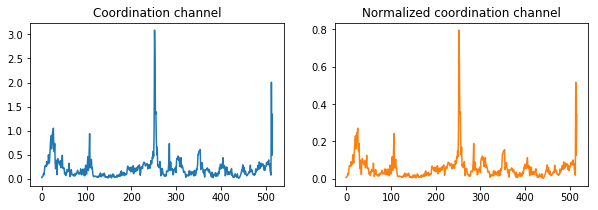

In [20]:
fig, axes = plt.subplots(figsize = (10, 3), ncols = 2)
axes[0].plot(channel)
axes[0].set_title('Coordination channel')
axes[1].plot(norm_channel, color = 'C1')
axes[1].set_title('Normalized coordination channel')


# Save coordination channel information to beta-column of a pdb file
Use with caution

In [25]:
# Create beta column for the pdb file
betas = np.empty(u.trajectory.n_atoms)
for i in range(channel.shape[0]):
    atom1 = int(str(u.residues[i].atoms[0]).split(':')[0].split(' ')[1])
    atom_1 = int(str(u.residues[i].atoms[-1]).split(':')[0].split(' ')[1])
    betas[atom1-1:atom_1] =channel[i]
betas = np.round_(betas, 2)

In [27]:
# Use the ref file pdb as a templete to write coordination-channel pdb
pdb = open(u_ref.trajectory.filename, 'rt')
pdb_out = open('channel-'+names[1]+'_'+names[2]+'.pdb', 'wt')
i = 0
for line in pdb:
    if 'ATOM' in line:
        if betas[i]<10:
            pdb_out.write(line.replace('0.00', "{:0.2f}".format(betas[i])))
        elif betas[i]<=-10:
            pdb_out.write(line.replace('  0.00', "{:0.2f}".format(betas[i])))            
        else:
            pdb_out.write(line.replace(' 0.00', "{:0.2f}".format(betas[i])))
        i+=1
pdb.close()
pdb_out.close()
